In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import torch.nn
import torch.optim
import torch.utils.data

# Problem 1

Use `np.histogram` to calculate the [probability density](https://en.wikipedia.org/wiki/Probability_density_function) that values in an arbitrary input data array fall within user-specified bins. Hint: `np.histogram` does all the work for you with the correct arguments.

In [3]:
def estimate_probability_density(data, bins):
    """Estimate the probability density of arbitrary data.
    
    Parameters
    ----------
    data : array
        1D numpy array of random values.
    bins : array
        1D numpy array of N+1 bin edges to use. Must be increasing.

    Returns
    -------
    array
        1D numpy array of N probability densities.
    """
    assert np.all(np.diff(bins) > 0)

    # YOUR CODE HERE
    
    counts, bins = np.histogram(data, bins, density=True)
    
    return counts
    
    raise NotImplementedError()

In [4]:
# A correct solution should pass these tests.
generator = np.random.RandomState(seed=123)
data = generator.uniform(size=100)
bins = np.linspace(0., 1., 11)
rho = estimate_probability_density(data, bins)
assert np.allclose(rho, [ 0.6,  0.8,  0.7,  1.7,  1.1,  1.3,  1.6,  0.9,  0.8,  0.5])
data = generator.uniform(size=1000)
bins = np.linspace(0., 1., 101)
rho = estimate_probability_density(data, bins)
dx = bins[1] - bins[0]
assert np.allclose(dx * rho.sum(), 1.)

# Problem 2

Define a function to calculate the [entropy](https://en.wikipedia.org/wiki/Entropy_estimation) $H(\rho)$ of a binned probability density, defined as:

$$H(\rho) \equiv -\sum_i \rho_i \log(\rho_i) \Delta w_i$$

where $\rho_i$ is the binned density in bin $i$ with width $w_i$.

In [5]:
def binned_entropy(rho, bins):
    """Calculate the binned entropy.
    
    Parameters
    ----------
    rho : array
        1D numpy array of densities, e.g., calculated by the previous function.
    bins : array
        1D numpy array of N+1 bin edges to use. Must be increasing.

    Returns
    -------
    float
        Value of the binned entropy.
    """
    assert np.all(np.diff(bins) > 0)
    
    # YOUR CODE HERE
    
    widths = np.empty(0) # creating list of widths of each bin
    for i in range(len(bins) - 1):
        widths = np.append(widths, bins[i+1] - bins[i])
    
    return -np.sum(rho * np.log(rho) * widths)
    
    raise NotImplementedError()


In [6]:
# A correct solution should pass these tests.
generator = np.random.RandomState(seed=123)
data1 = generator.uniform(size=10000)
data2 = generator.uniform(size=10000) ** 4
bins = np.linspace(0., 1., 11)
rho1 = estimate_probability_density(data1, bins)
rho2 = estimate_probability_density(data2, bins)
H1 = binned_entropy(rho1, bins)
H2 = binned_entropy(rho2, bins)
assert np.allclose(H1, -0.000801544)
assert np.allclose(H2, -0.699349908)

# Problem 3

We're going to implement a network that will do multi-category classification.  We'll base this on the tools we developed in the [NeuralNetworks2](https://git.ucsc.edu/mhance/phys152/-/blob/master/Notebooks/NeuralNetworks2.ipynb) notebook from class.

First let's load in the data file.  You can find the data file in the HW area of my gitlab repo: [HW2_data.h5](https://git.ucsc.edu/mhance/phys152/-/blob/master/HW/HW2_data.h5)

In [15]:
import h5py
h5f = h5py.File('HW2_data.h5','r')
x_train= h5f['x_train'][:]
y_train= h5f['y_train'][:]
x_test= h5f['x_test'][:]
y_test= h5f['y_test'][:]
h5f.close()

torch.manual_seed(123)

(1000, 4)
(1000,)


In [29]:
print(np.shape(x_train))
print(np.shape(y_train))
print(y_train)

(1000, 4)
(1000,)
[0 0 1 1 2 2 2 2 2 1 1 1 1 1 2 1 0 1 0 2 2 1 0 2 2 1 2 1 0 2 2 2 2 1 1 1 0
 2 2 1 0 2 0 0 0 2 1 1 0 1 1 2 0 2 1 2 0 0 0 2 1 1 2 0 1 2 1 0 2 2 1 0 0 0
 1 2 0 2 0 1 1 2 1 2 0 1 0 0 2 0 0 0 1 0 0 2 1 0 1 0 0 2 2 0 0 0 1 2 2 2 0
 2 0 1 1 2 2 1 0 2 0 0 0 2 0 0 0 1 0 0 1 0 0 2 2 2 2 0 0 2 2 1 2 0 2 2 2 0
 1 1 1 1 2 2 0 1 1 0 1 1 2 2 2 0 1 2 0 1 0 0 2 0 0 1 0 0 0 0 2 1 0 2 1 0 2
 0 0 0 1 0 1 0 0 2 0 1 2 0 2 2 0 0 0 1 0 1 0 1 0 2 0 0 0 1 1 1 0 2 0 1 1 2
 0 1 2 0 1 2 0 2 2 1 2 1 1 2 0 1 1 0 1 1 1 2 1 0 1 0 1 0 1 2 0 1 1 2 1 1 0
 0 2 2 0 0 1 2 0 1 0 1 2 0 0 1 2 0 1 0 1 0 2 2 2 1 0 1 0 0 0 1 0 0 0 1 0 0
 2 2 2 2 2 1 2 2 1 2 1 2 1 2 1 2 2 0 0 2 2 1 2 2 0 0 1 2 2 2 2 0 1 1 2 2 2
 1 2 2 0 1 1 1 1 0 1 2 2 1 1 0 2 0 0 0 1 1 2 2 1 2 0 2 2 2 1 0 2 1 2 2 2 0
 1 0 2 2 1 1 0 0 1 1 1 1 0 1 1 2 0 1 0 1 2 2 0 0 1 0 0 2 1 0 1 2 2 1 0 1 2
 0 0 2 2 2 1 2 0 0 1 0 2 1 1 2 2 2 1 0 0 2 0 0 1 0 1 1 0 1 1 1 1 1 2 2 0 2
 0 0 0 2 2 1 1 1 0 0 1 1 2 2 1 1 0 0 0 1 1 2 0 0 2 0 1 1 1 0 0 1 0 1 0 0 0
 2 1 0 

(array([354.,   0., 328.,   0., 318.,   0.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. ]),
 <BarContainer object of 6 artists>)

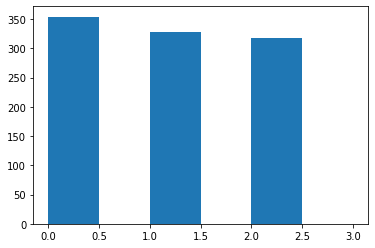

In [9]:
plt.hist(y_train,bins=(np.max(y_train)+1)*2,range=(0,np.max(y_train)+1))

Now the fun part.  Let's construct a similar network to what we used in class: 
- 2 hidden layers, with 20 and 25 nodes respectively, using ReLU activation functions.  
- The number of input layers should correspond to the number of features in the training/test data, and the number of output layers should correspond to the number of categories in the training/test data.  In this case, the `y_train` and `y_test` lists will show the category label as a number between `0` and `C`, where `C` is the total number of categories.  You should inspect the training/test data to figure out the number of features and the number of categories.
- For the loss function, we should use `torch.nn.CrossEntropyLoss()`.  This implements the `softmax` activation function on the output layer that we'll use for multi-category classification.
- Let's use the Adam optimizer, starting with a learning rate of 0.1
- Break the training data into 5 batches and run for 1000 epochs

Then you can train the network!  Keep track of the loss values for the training and test data, and plot them vs the epoch number after the training is completed.

The predictions of the network will be a set of `C` numbers for each event, corresponding to the probability that the event is classified as each of the `C` different categories.  We should take the maximum value for each set of `C` numbers to determine the category label.  So if the output for event 0 looks like `[0.8, 0.6, 0.95, 0.10]` and the categories are numbered `0..3` then the predicted label would be `2`.

Once the network is trained, let's inspect the output.  Using the predictions for the training data, construct a "confusion matrix", showing the true labels on one axis and the predicted labels on the other.

I can offer more clarifications on this as the HW period goes on, so feel free to ask questions as you start on this one!

In [22]:
# creating the net

net = torch.nn.Sequential(
    torch.nn.Linear(4, 20), # 4 input features going into 20 nodes
    torch.nn.ReLU(),
    torch.nn.Linear(20, 25), # 20 nodes into 25 nodes
    torch.nn.ReLU(),
    torch.nn.Linear(25, 1), # 1 output
)


In [23]:
torch.save(net.state_dict(), 'net.pth') # saving the network

In [24]:
loss = torch.nn.CrossEntropyLoss()

In [26]:
optimizier = torch.optim.Adam( net.parameters(), lr = 0.1)

In [ ]:
loss_train = np.empty(0)

